# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# My laptop started hanging if I tried to use all the reviews, hence i prepared the model using 100000 reviews.

In [62]:
# using SQLite Table to read data.
db1 = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", db1) 
#
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(polarity) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [63]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", db1)

In [64]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [65]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [66]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [67]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [68]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [69]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [70]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [71]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


positive    73592
negative    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [72]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [73]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [74]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (87773, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,negative,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infest fruitfli liter everywher fli around kit...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,negative,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate star...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,negative,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish read review make purchas basic cardsotck ...


In [133]:
#Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# We will collect different 10k rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data.take(np.random.permutation(len(final))[:5000])
print(my_final.shape)
my_final.head()

(5000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
34038,37040,B000ARTNRE,A31AIKN6FD3MEW,amazon-mom,0,0,positive,1329436800,i always keep these for back up,"these are great to have on hand for back up , ...",great hand back run powder formula love babi l...
87052,94764,B004DDM2PG,A1TC0DI0DR4WCK,Lisa Guo,1,1,positive,1301702400,Delicious!,"I'm very picky about my candy, especially my g...",picki candi especi gummi gummi sticki get stuc...
16908,18450,B001IZICAG,A1M6YAC8LOFIUV,Marcel C. Fromond,5,5,positive,1314835200,Good product,This is a good product.<br />As it becomes inc...,good product becom increas difficult find anch...
39032,42377,B000F0FX52,A365IPND6FFKQR,big bob,2,2,positive,1313280000,would recommend,"three main complaints, otherwise happy. The pl...",three main complaint otherwis happi plastic us...
3213,3498,B005K4Q1VI,A3Q307658TBYCR,Shirley A Sluskonis,1,1,positive,1326326400,Great,"Best K-cup hot cocoa on the market, bar none. ...",best hot cocoa market bar none would without h...


In [134]:
#Ratio of positive is to negative
len(my_final[my_final['Score'] == 'positive'])/len(my_final[my_final['Score'] == 'negative'])

5.313131313131313

In [135]:
len(final[final['Score'] == 'positive'])/len(final[final['Score'] == 'negative'])

5.189478880191806

Here the ratio is almost same, hence good to go.

<h2><font color='black'>[3.2] Segregating the reviews into test and train</font></h2>

In [136]:
## Similartly you can do preprocessing for review summary also.

In [137]:
#Segregating into test and train

from sklearn.model_selection import train_test_split


x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# 4. Featurizing

## [4.1] BAG OF WORDS

In [138]:
#BoW
count_vect = CountVectorizer(min_df=10) #in scikit-learn
X_train_vec= count_vect.fit_transform(X_train)
X_test_vec= count_vect.transform(X_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer ",type(X_train_vec))
print("the shape of out text BOW vectorizer ",X_train_vec.get_shape())
print("the number of unique words ", X_train_vec.get_shape()[1])

some feature names  ['abl', 'absolut', 'absorb', 'accept', 'accord', 'accustom', 'acid', 'across', 'act', 'activ']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3500, 1628)
the number of unique words  1628


# [4.2] 3-fold CV (Brute Force approach)

In [139]:
# Importing libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 9.


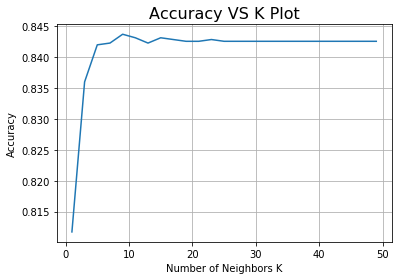


 Accuracy for each k value is :  [0.812 0.836 0.842 0.842 0.844 0.843 0.842 0.843 0.843 0.843 0.843 0.843
 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843
 0.843]


In [140]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [141]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_brute_K = optimal_k
bow_brute_train_acc = max(cv_scores)*100
bow_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 9 is 84.200000%


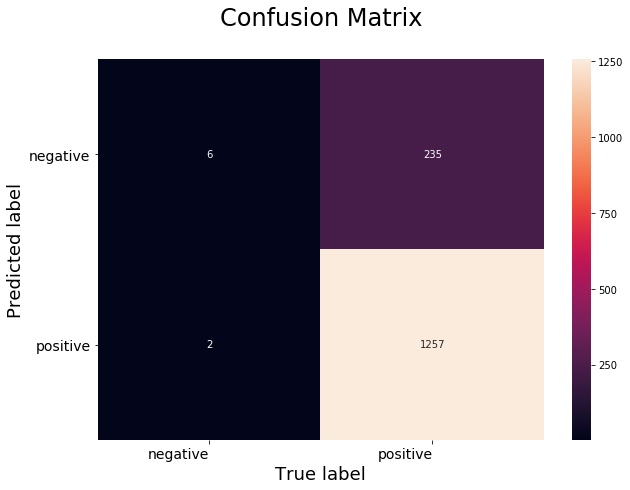

In [142]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [4.3] 3 Fold Cross-Validation (kd_tree implementation)¶


In [181]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)


# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 13.


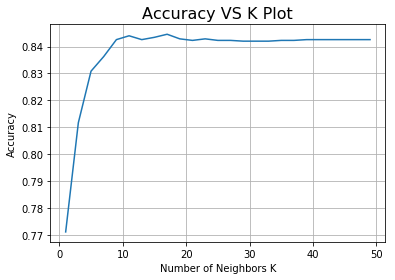


 Accuracy for each k value is :  [0.771 0.812 0.831 0.836 0.843 0.844 0.843 0.843 0.845 0.843 0.842 0.843
 0.842 0.842 0.842 0.842 0.842 0.842 0.842 0.843 0.843 0.843 0.843 0.843
 0.843]


In [144]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [145]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_kdTree_K = optimal_k
bow_kdTree_train_acc = max(cv_scores)*100
bow_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 17 is 84.200000%


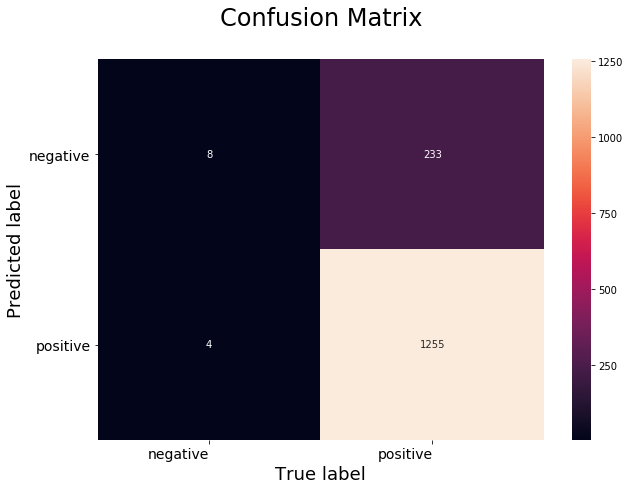

In [146]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [4.3] TF-IDF

In [147]:
tf_idf_vect = TfidfVectorizer(min_df=50)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3500, 511)
the number of unique words : 511


# 3 fold CV (Brute force approach)

In [148]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, X_train_vec, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 13.


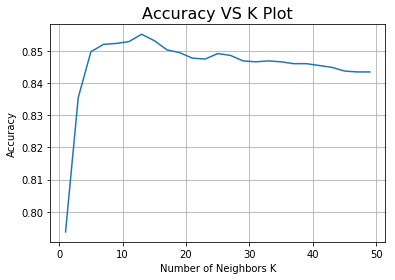


 Accuracy for each k value is :  [0.794 0.835 0.85  0.852 0.852 0.853 0.855 0.853 0.85  0.849 0.848 0.847
 0.849 0.849 0.847 0.847 0.847 0.847 0.846 0.846 0.845 0.845 0.844 0.843
 0.843]


In [149]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [150]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_brute_K = optimal_k
tfidf_brute_train_acc = max(cv_scores)*100
tfidf_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 13 is 84.866667%


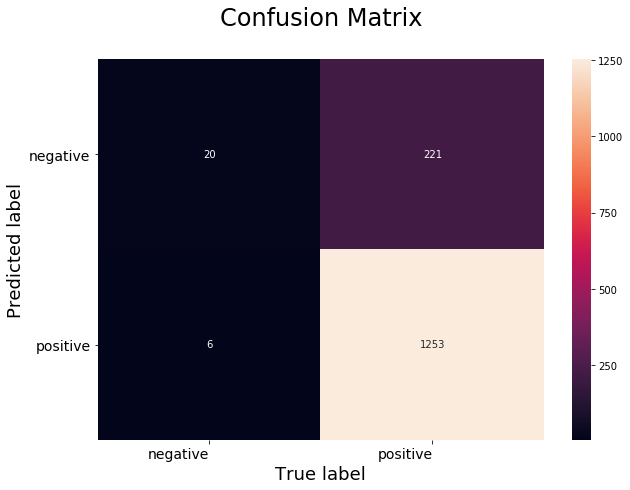

In [151]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 fold CV (kd-tree)

In [152]:
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_vec)
X_test_vec_dense = svd.transform(X_test_vec)

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, X_train_vec_dense, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 21.


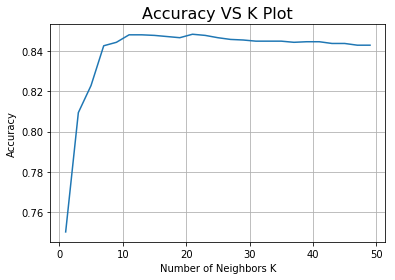


 Accuracy for each k value is :  [0.75  0.809 0.823 0.843 0.844 0.848 0.848 0.848 0.847 0.847 0.848 0.848
 0.847 0.846 0.845 0.845 0.845 0.845 0.844 0.845 0.845 0.844 0.844 0.843
 0.843]


In [153]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [154]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(X_train_vec_dense, Y_train)

# predict the response
pred = knn_optimal.predict(X_test_vec_dense)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_kdTree_K = optimal_k
tfidf_kdTree_train_acc = max(cv_scores)*100
tfidf_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 21 is 84.466667%


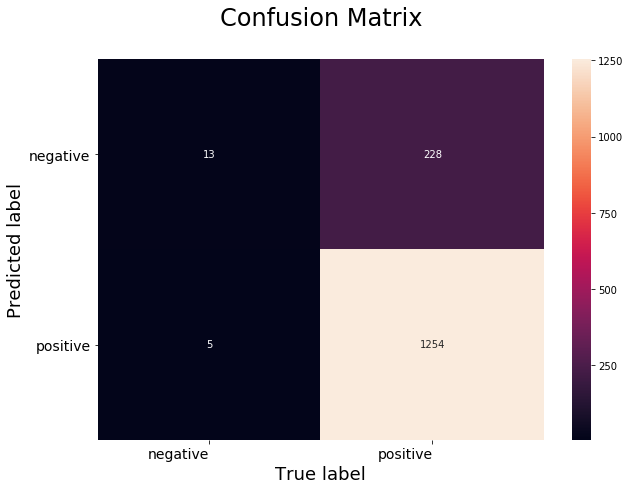

In [155]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

## [4.4] Word2Vec

In [156]:
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  2719


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [157]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)

# 3 Fold Cross-Validation (Brute force implementation)

In [158]:

# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)



The optimal number of neighbors is 39.


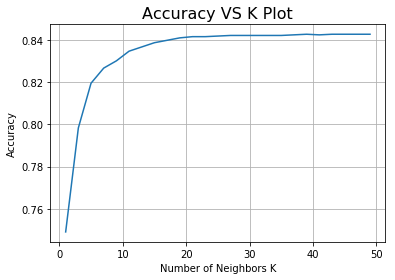


 Accuracy for each k value is :  [0.749 0.798 0.819 0.827 0.83  0.835 0.837 0.839 0.84  0.841 0.841 0.841
 0.842 0.842 0.842 0.842 0.842 0.842 0.842 0.843 0.842 0.843 0.843 0.843
 0.843]


In [159]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [160]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_brute_K = optimal_k
Avg_Word2Vec_brute_train_acc = max(cv_scores)*100
Avg_word2Vec_brute_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 39 is 83.933333%


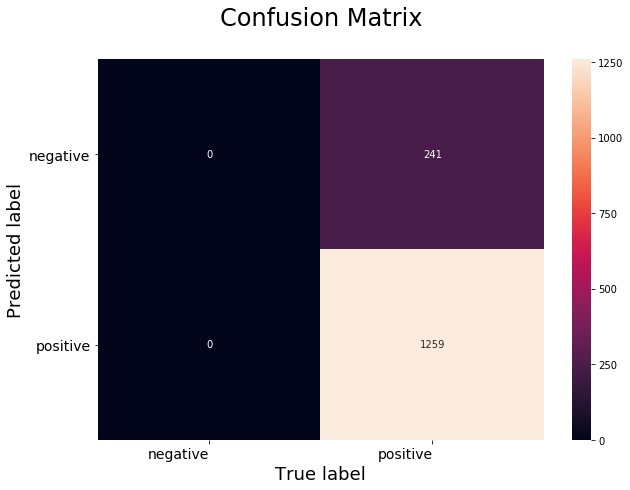

In [161]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# kd-tree

In [162]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 39.


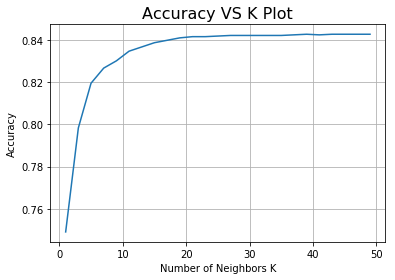


 Accuracy for each k value is :  [0.749 0.798 0.819 0.827 0.83  0.835 0.837 0.839 0.84  0.841 0.841 0.841
 0.842 0.842 0.842 0.842 0.842 0.842 0.842 0.843 0.842 0.843 0.843 0.843
 0.843]


In [163]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [164]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree', n_jobs=-1)

# fitting the model
knn_optimal.fit(train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
Avg_Word2Vec_kdTree_K = optimal_k
Avg_Word2Vec_kdTree_train_acc = max(cv_scores)*100
Avg_Word2Vec_kdTree_test_acc = acc



The Test Accuracy of the K-NN classifier for k = 39 is 83.933333%


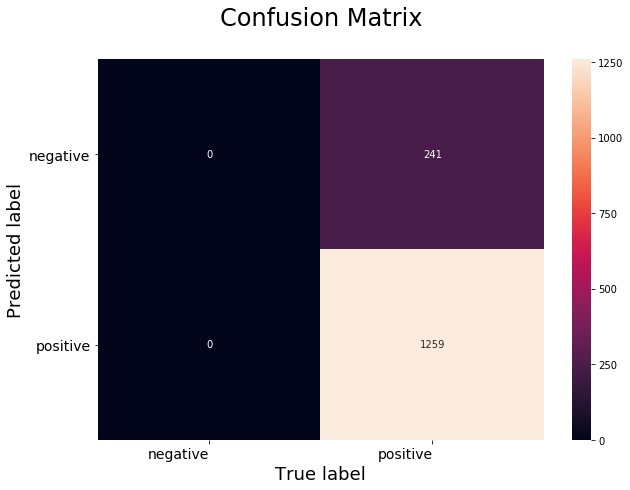

In [165]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

#### [4.4.1.2] TFIDF weighted W2v

In [166]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1  
    
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1

# 3 Fold Cross-Validation (Brute force implementation)


In [167]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


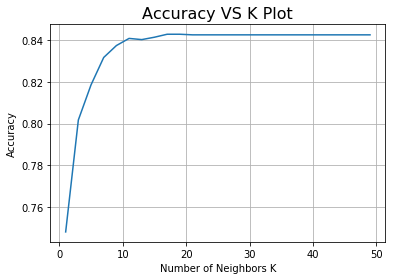


 Accuracy for each k value is :  [0.748 0.802 0.819 0.832 0.837 0.841 0.84  0.841 0.843 0.843 0.843 0.843
 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843
 0.843]


In [168]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [169]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_brute_K = optimal_k
TFIDF_Word2Vec_brute_train_acc = max(cv_scores)*100
TFIDF_word2Vec_brute_test_acc = acc




The Test Accuracy of the K-NN classifier for k = 19 is 83.866667%


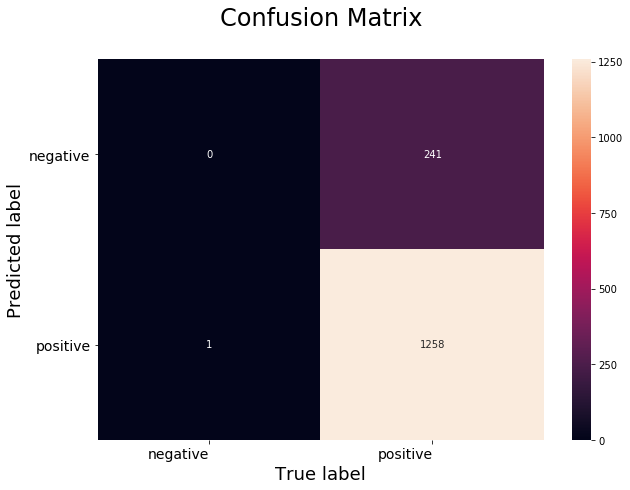

In [170]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3 Fold Cross-Validation (kd-tree implementation)


In [171]:
# creating odd list of K for KNN
myList = list(range(0,50))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
    scores = cross_val_score(knn, tfidf_train_vectors, Y_train, cv=3, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)


The optimal number of neighbors is 19.


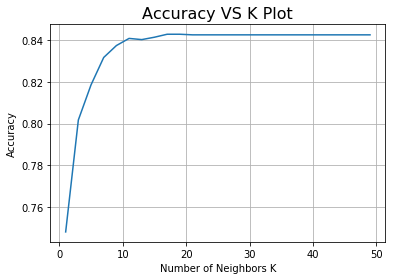


 Accuracy for each k value is :  [0.748 0.802 0.819 0.832 0.837 0.841 0.84  0.841 0.843 0.843 0.843 0.843
 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843 0.843
 0.843]


In [172]:
# plot accuracy vs k 
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.title('Accuracy VS K Plot',size=16)
plt.grid()
plt.show()

print("\n Accuracy for each k value is : ", np.round(cv_scores,3))

In [173]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute', n_jobs=-1)

# fitting the model
knn_optimal.fit(tfidf_train_vectors, Y_train)

# predict the response
pred = knn_optimal.predict(tfidf_test_vectors)

# evaluate accuracy
acc = accuracy_score(Y_test, pred) * 100
print('\nThe Test Accuracy of the K-NN classifier for k = %d is %f%%' % (optimal_k, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
TFIDF_Word2Vec_kdTree_K = optimal_k
TFIDF_Word2Vec_kdTree_train_acc = max(cv_scores)*100
TFIDF_Word2Vec_kdTree_test_acc = acc


The Test Accuracy of the K-NN classifier for k = 19 is 83.866667%


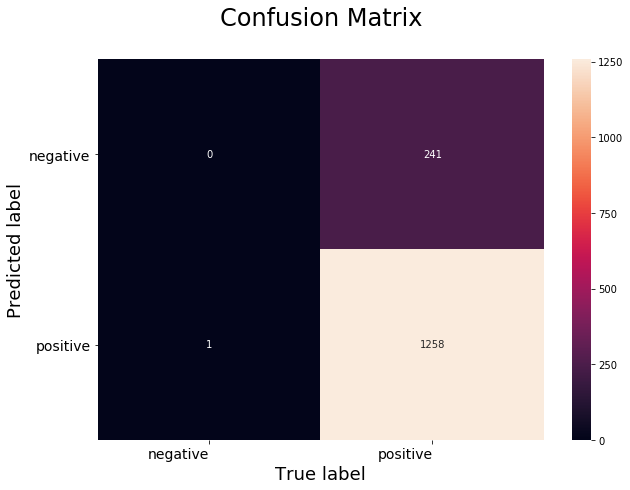

In [174]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, pred), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# [6]Conclusions_PrettyTable

In [178]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["brute BoW", "kdTree BoW", "brute TFIDF", \
        "kdTree TFIDF", "brute Avg-Word2Vec", "kdTree Avg-Word2Vec", \
        "brute TFIDF-Word2Vec", "kdTree TFIDF-Word2Vec"]

optimal_K = [bow_brute_K, bow_kdTree_K, tfidf_brute_K, tfidf_kdTree_K, Avg_Word2Vec_brute_K, Avg_Word2Vec_kdTree_K, \
             TFIDF_Word2Vec_brute_K, TFIDF_Word2Vec_kdTree_K]

train_acc = [bow_brute_train_acc, bow_kdTree_train_acc, tfidf_brute_train_acc, tfidf_kdTree_train_acc, \
             Avg_Word2Vec_brute_train_acc, Avg_Word2Vec_kdTree_train_acc, TFIDF_Word2Vec_brute_train_acc, \
             TFIDF_Word2Vec_kdTree_train_acc]

test_acc = [bow_brute_test_acc, bow_kdTree_test_acc, tfidf_brute_test_acc, tfidf_kdTree_test_acc, \
            Avg_word2Vec_brute_test_acc, Avg_Word2Vec_kdTree_test_acc, TFIDF_word2Vec_brute_test_acc, \
            TFIDF_Word2Vec_kdTree_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",optimal_K)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-----------------------+--------+-------------------+-------------------+
| S.NO. |         MODEL         | Best K | Training Accuracy |   Test Accuracy   |
+-------+-----------------------+--------+-------------------+-------------------+
|   1   |       brute BoW       |   9    | 84.37140968789608 |        84.2       |
|   2   |       kdTree BoW      |   17   | 84.45705049721153 |        84.2       |
|   3   |      brute TFIDF      |   13   | 85.51435683899186 | 84.86666666666667 |
|   4   |      kdTree TFIDF     |   21   | 84.82844646690016 | 84.46666666666667 |
|   5   |   brute Avg-Word2Vec  |   39   |  84.2571566173448 | 83.93333333333334 |
|   6   |  kdTree Avg-Word2Vec  |   39   |  84.2571566173448 | 83.93333333333334 |
|   7   |  brute TFIDF-Word2Vec |   19   | 84.28574438178164 | 83.86666666666667 |
|   8   | kdTree TFIDF-Word2Vec |   19   | 84.28574438178164 | 83.86666666666667 |
+-------+-----------------------+--------+-------------------+-------------------+


# Endnote